# Pair Trading for The UK Market


- Retrieve the spread between the two pairs.
- Is the Spread Mean Reverting?
- Compute rolling correlation between imbalance price and spot price.
- Elaborate the pair trading strategy

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from scipy.stats import norm
from statistics import NormalDist
from itertools import product
from hurst import compute_Hc
from pykalman import KalmanFilter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


from AnalyticsModules import devotools as dvt
from AnalyticsModules.cleandata import CleanData
from AnalyticsModules.correlation import ClassicCorrelation
from BackTestModules.Strategy.PairTrading import ZPairUK, KSPairUK

%load_ext autoreload
%autoreload 2

In [2]:
raw = pd.read_csv('data/DOLCE.csv', delimiter = ';', parse_dates = True, index_col = 'time', sep = '\t', decimal = ',')

In [3]:
data = raw[['buy_price', 'spot_uk']].dropna()

data.rename(columns = {'buy_price': 'imb_uk'}, inplace = True)

In [4]:
data['spread'] = data['imb_uk'].subtract(data['spot_uk'])

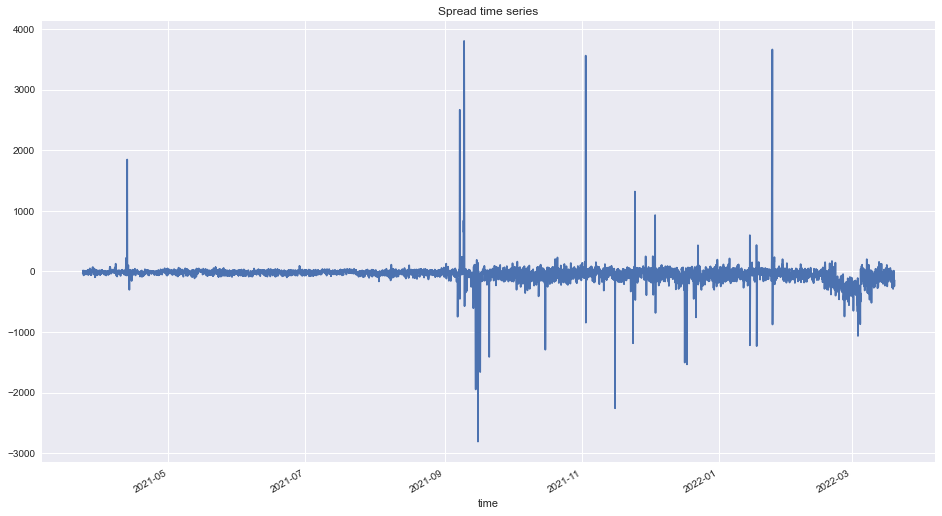

In [5]:
data.spread.plot(figsize = (16,9), grid = True, title = 'Spread time series')

In [6]:
data.describe()

,imb_uk,spot_uk,spread
count,8662.000000,8662.000000,8662.000000
mean,142.304328,182.974655,-40.670327
std,151.070970,143.369958,162.257039
min,-90.320000,-59.500000,-2808.150000
25%,77.500000,94.895000,-68.167500
50%,117.750000,150.510000,-22.015000
75%,187.202500,225.377500,8.620000
max,4037.800000,2923.650000,3804.030000


In [7]:
f = round(np.quantile(data.spread, 0.05),2)

filtered = data.query(f'spread >= {f} & spread <= {-f}')

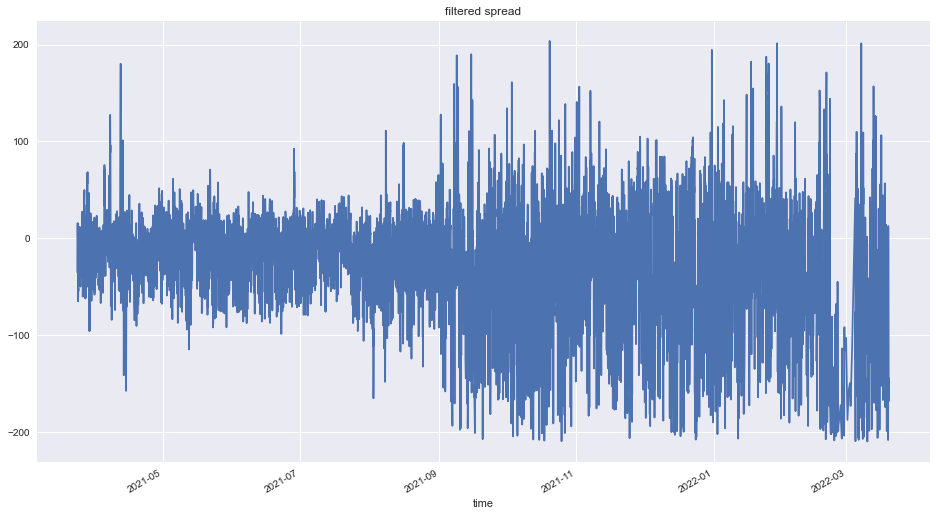

In [8]:
filtered.spread.plot(figsize = (16,9), grid = True, title = 'filtered spread')

In [9]:
dvt.dickey_fuller_test(filtered.spread)

Augmented Dickey-Fuller test
Test statistic: -10.8738
-----------------------------------
p-value: 1.3478310211070554e-19
-----------------------------------
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Hypothesis Testing Results
Reject null Hyptothesis (H0): True


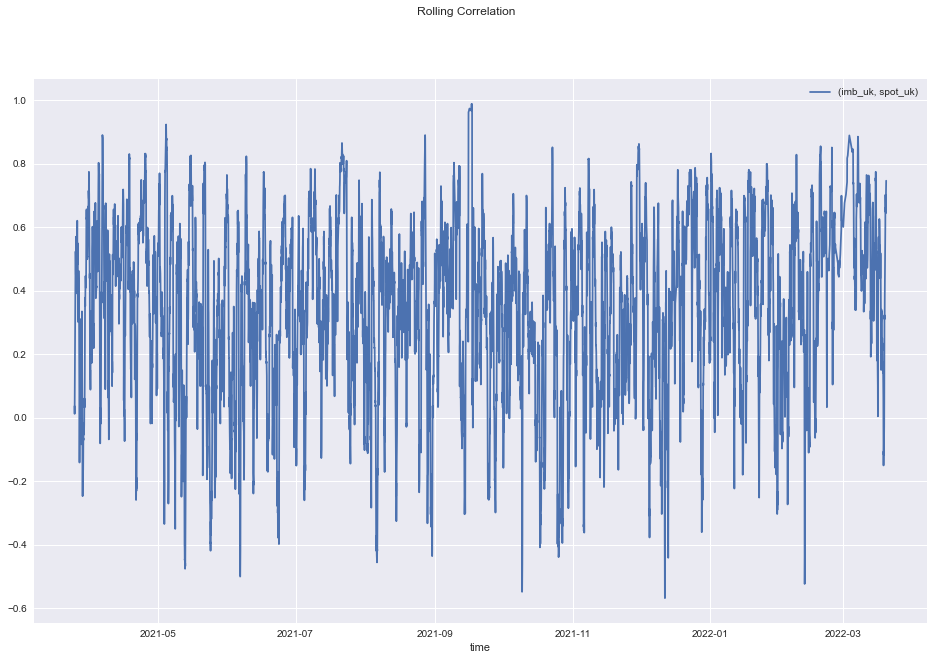

In [10]:
corr = ClassicCorrelation(filtered[['imb_uk', 'spot_uk']], method = 'pearson')
corr.rolling_correlation(window = 24)

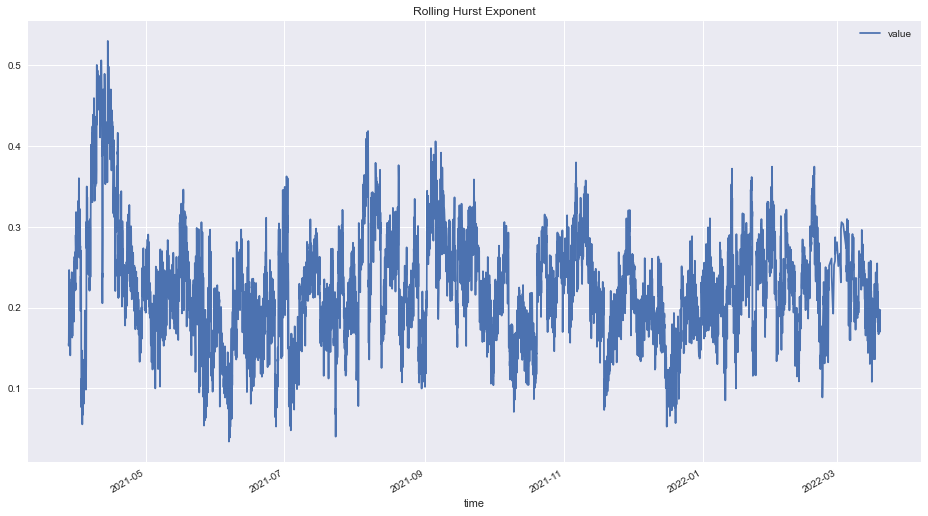

In [11]:
dvt.rolling_hurst(filtered.spread, lags = 100, plot = True)

# Testing The Strategy: Pair Trading with the ZScore technique.

In [12]:
training_size = math.ceil(0.7 * filtered.shape[0])

X_train = filtered[:training_size]
X_test = filtered[training_size:]

Return Multiplier: 1.0656560233549597 | sma = 4  ...
STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: 71.446212
----------------------------------------------------------------------------------------------------
Number of Trades: 12.0
Number of profitable trades: 5
Number of unprofitable trades: 7.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.13
Hit Ratio: 0.42


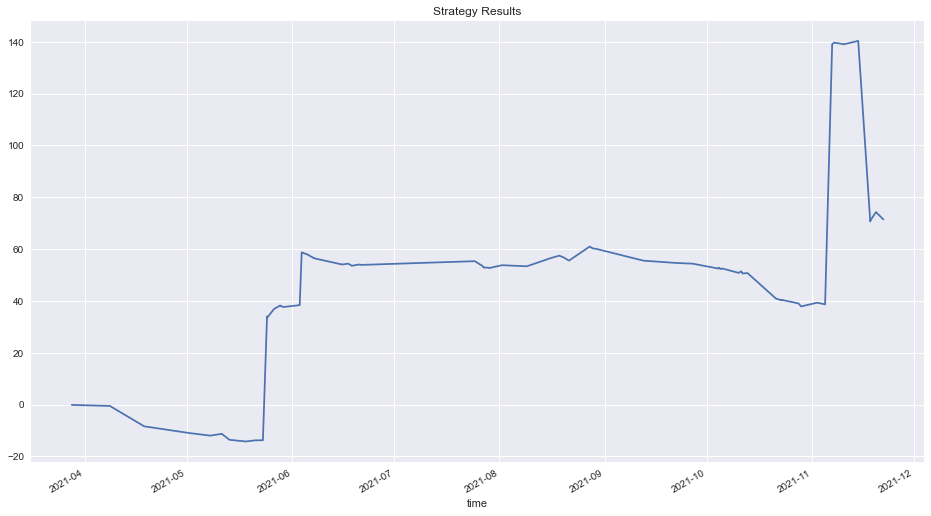

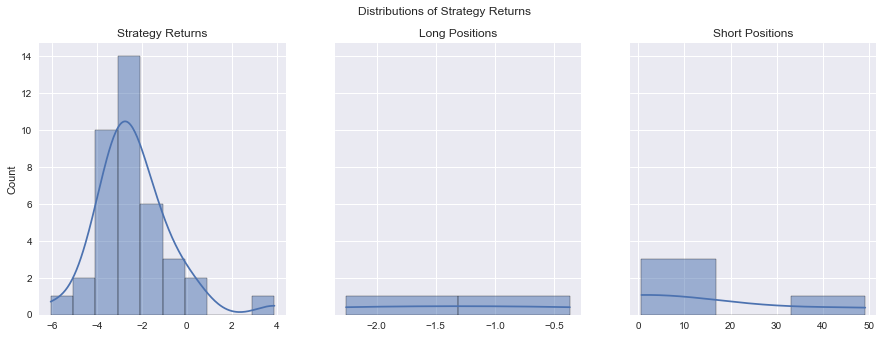

In [13]:
ptz = ZPairUK(X_train, scaler = 'standard')

sma_range = [4,24,2]

ptz.optimize_strategy(sma_range)
ptz.plot_results()
ptz.plot_diagnostics(no_log = True)

# Testing the strategy: Pair Trading with the Kalman Filter

Return Multiplier: 0.9648637714527466 | sma = 4  ...
STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: 47.768003
----------------------------------------------------------------------------------------------------
Number of Trades: 10.0
Number of profitable trades: 5
Number of unprofitable trades: 5.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.13
Hit Ratio: 0.50


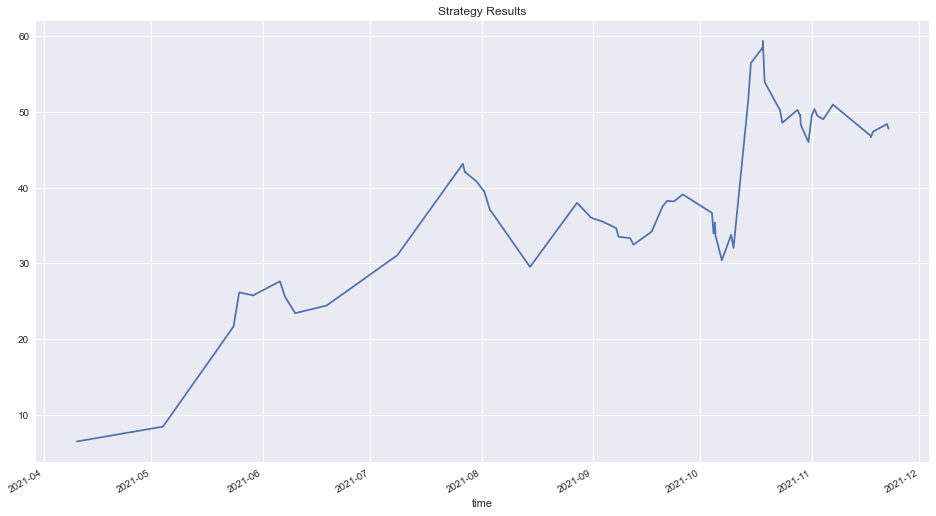

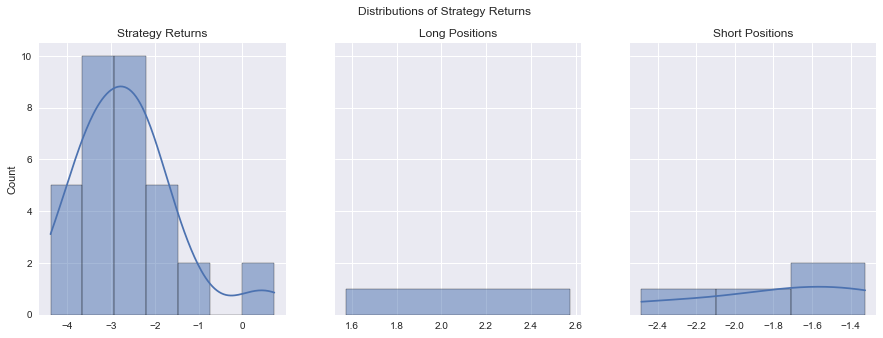

In [14]:
ptk = KSPairUK(X_train)

ptk.optimize_strategy(sma_range)
ptk.plot_results()
ptk.plot_diagnostics(no_log = True)

STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: 70.452807
----------------------------------------------------------------------------------------------------
Number of Trades: 6.0
Number of profitable trades: 3
Number of unprofitable trades: 3.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.10
Hit Ratio: 0.50


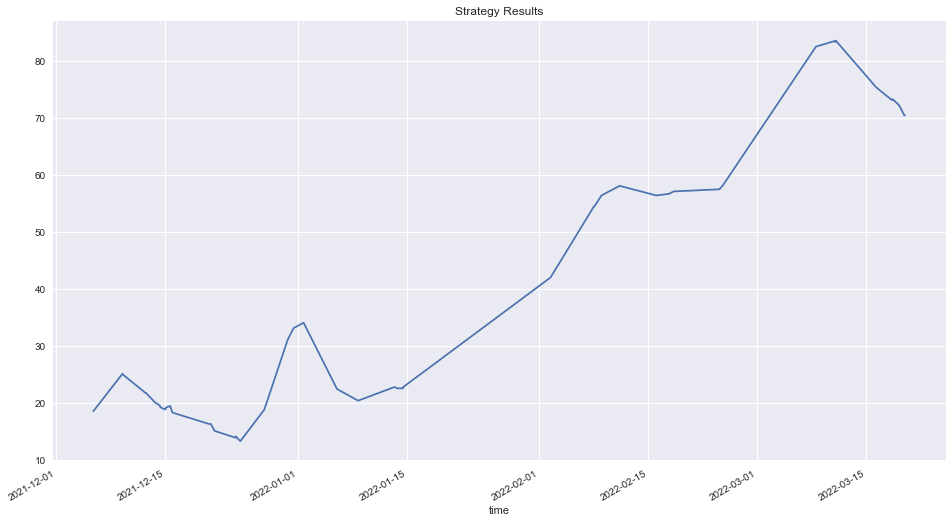

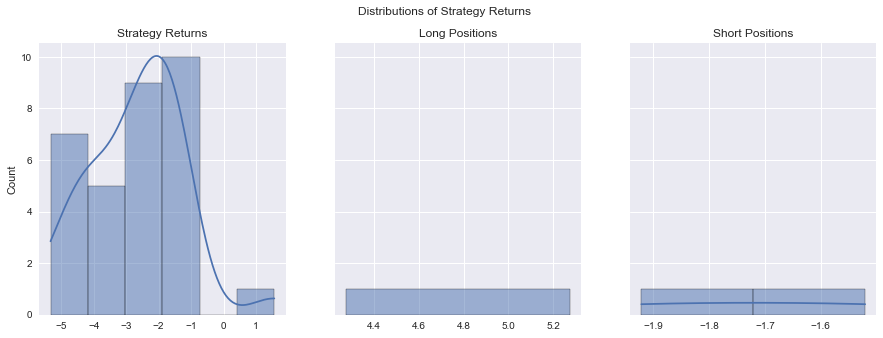

In [15]:
ptk_test = KSPairUK(X_test)
ptk_test.test_strategy(sma = 4)

ptk_test.plot_results()
ptk_test.plot_diagnostics(no_log = True)